In [14]:
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import dct, idct
import pywt
from math import log10, sqrt 
import cv2 
import numpy as np 
from skimage.metrics import structural_similarity as SSIM

Image dimensions: (450, 620, 3)


(-0.5, 619.5, 449.5, -0.5)

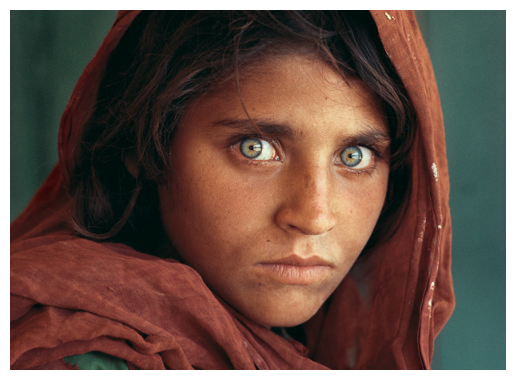

In [2]:
img = imread('afghan.jpg')

print('Image dimensions:', img.shape)

plt.figure()
plt.imshow(img)
plt.axis('off')

In [3]:
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')
               
def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

def dct_compression_rgb(img, threshold=0.1):
    compressed_channels = []
    for i in range(3):
        channel_dct = dct2(img[:, :, i])
        channel_sort = np.sort(np.abs(channel_dct.reshape(-1)))

        thresh = channel_sort[int(np.floor((1-threshold) * len(channel_sort)))]
        ind = np.abs(channel_dct) > thresh
        channel_compressed = channel_dct * ind
        channel_reconstructed = idct2(channel_compressed).real

        compressed_channels.append(channel_reconstructed)
    compressed_image = np.stack(compressed_channels, axis=-1)
    compressed_image = np.clip(compressed_image, 0, 255)
    
    return compressed_image


In [4]:
def fft_compression_rgb(img, threshold=0.1):
    compressed_channels = []
    for i in range(3):
        channel_dct = np.fft.fft2(img[:, :, i])
        channel_sort = np.sort(np.abs(channel_dct.reshape(-1)))

        thresh = channel_sort[int(np.floor((1-threshold) * len(channel_sort)))]
        ind = np.abs(channel_dct) > thresh
        channel_compressed = channel_dct * ind
        channel_reconstructed = np.fft.ifft2(channel_compressed).real

        compressed_channels.append(channel_reconstructed)
    compressed_image = np.stack(compressed_channels, axis=-1)
    compressed_image = np.clip(compressed_image, 0, 255)
    
    return compressed_image

In [5]:
def wavelet_compression_rgb(img, threshold = 0.1):
    compressed_channels = []
    n = 4
    wavelet_function = 'db1'
    for i in range(3):
        coeffs = pywt.wavedec2(img[:, :, i],wavelet=wavelet_function, level=n)
        
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

        thresh = Csort[int(np.floor((1-threshold) * len(Csort)))]
        ind = np.abs(coeff_arr) > thresh
        Cfilt = coeff_arr * ind
        
        coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedec2')
        
        channel_reconstructed = pywt.waverec2(coeffs_filt, wavelet = wavelet_function)

        compressed_channels.append(channel_reconstructed)
    compressed_image = np.stack(compressed_channels, axis=-1)
    compressed_image = np.clip(compressed_image, 0, 255)
    
    return compressed_image

In [9]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0): 
        return 100
    
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    
    return psnr 

In [28]:
def SSIM_RGB(img1, img2):
    if img1.shape != img2.shape:
            raise ValueError("Input images must have the same dimensions")
    ssim_sum = 0.0
        
    for i in range(3):
        ssim_sum += SSIM(img1[:,:,i], img2[:,:,i], multichannel=True,data_range=255)

    return ssim_sum / 3.0

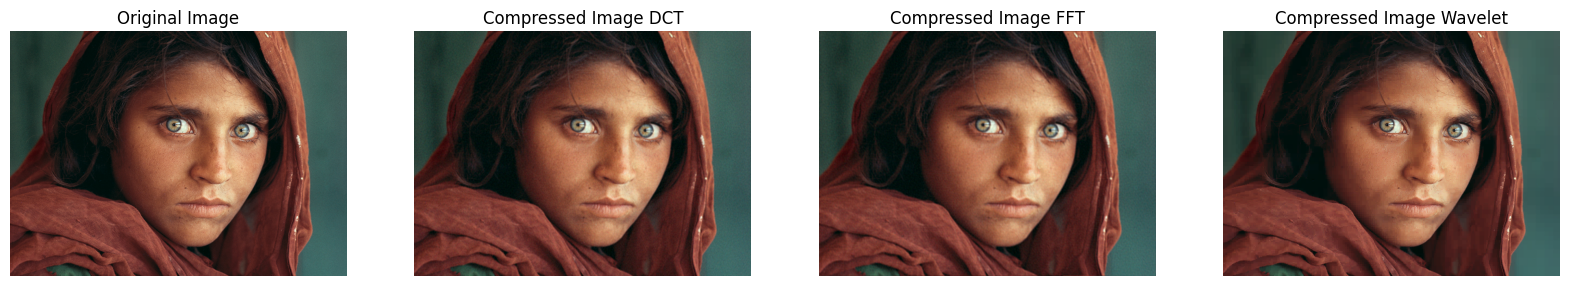

In [12]:
compressed_image_dct = dct_compression_rgb(img, threshold=0.1)
compressed_image_fft = fft_compression_rgb(img, threshold=0.1)
compressed_image_wavelet = wavelet_compression_rgb(img, threshold=0.1)

plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(compressed_image_dct.astype(np.uint8))
plt.title('Compressed Image DCT')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(compressed_image_fft.astype(np.uint8))
plt.title('Compressed Image FFT')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(compressed_image_wavelet.astype(np.uint8))
plt.title('Compressed Image Wavelet')
plt.axis('off')
plt.show()

In [13]:
print('PSNR Wavelets:', PSNR(img, compressed_image_wavelet))
print('PSNR fft:', PSNR(img, compressed_image_fft))
print('PSNR dct:', PSNR(img, compressed_image_dct))

PSNR Wavelets: 36.19832886327237
PSNR fft: 33.87596482501906
PSNR dct: 34.83121721289895


In [31]:
print('SSIM Wavelets:', SSIM_RGB(img, compressed_image_wavelet))
print('SSIM fft:', SSIM_RGB(img, compressed_image_fft))
print('SSIM dct:', SSIM_RGB(img, compressed_image_dct))

SSIM Wavelets: 0.8904182384573622
SSIM fft: 0.8547595363288019
SSIM dct: 0.8733662337373267
